## 此專案用於開發 RUL 預測程式的最終版本, 此處先以單點分析再推廣至多工況 ##
### 此程式用於測試 類磁通估測器 的異常診斷成果 ###
### 模型採用 雙LSTM層轉譯預測序列 ###
### 2025 0731 ###



### 導入模型設定與套件 ###

In [83]:
# import used functioons 
#  import tools 
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, Dense, concatenate, RepeatVector, MaxPooling1D, Activation ,UpSampling1D, Conv1DTranspose
from tensorflow.keras.layers import Add, Concatenate,LSTM, TimeDistributed, MultiHeadAttention, LayerNormalization


from tensorflow.keras.utils import plot_model

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU devices found:")
    for gpu in gpus:
        print(gpu)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import numpy as np 
import pandas as pd
from openpyxl import Workbook
import matplotlib.pyplot as plt
import os
import sys
import csv
import time
from IPython import embed

from rul_features.rul_data_read import read_rul_data

from test_algs.CCAE_ntu_rul import get_initial_files_datalist, CCAE_train
from test_algs.CCAE_ntu_rul import CCAE_model_application, CCAE_model_build_train

import random
np.random.seed(42)
random.seed(42)



GPU devices found:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## 建立 LSTM 預測模型架構 ##
I2 in I2 out

### 確立訓練工況檔案來源 ###
使用 CCAE 範本作為正常工況

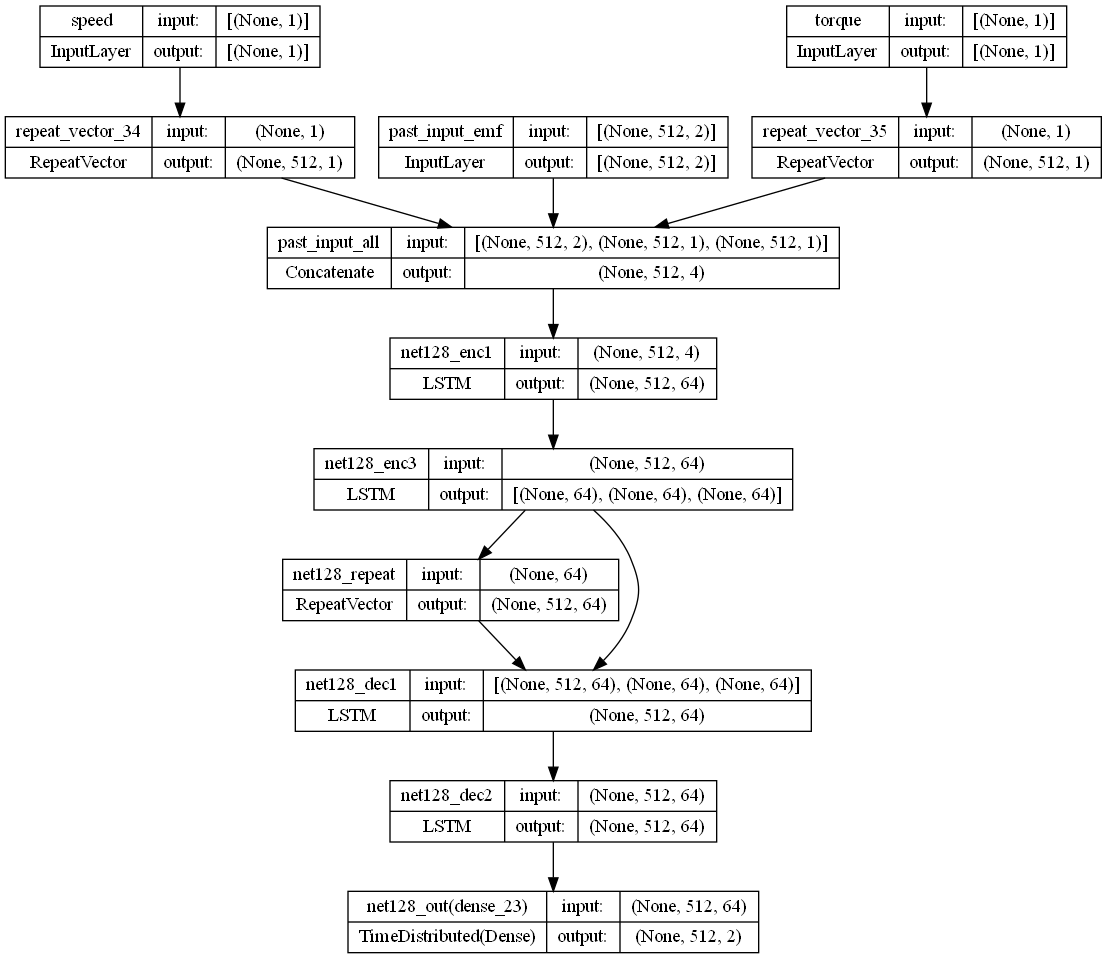

In [84]:
from datetime import datetime
import json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense, Average, Add, Multiply, Lambda, GlobalAveragePooling1D
from tensorflow.keras import backend as K

# Initial model parameters
sequence_length=512
layer_number=1
future_length=512

model_folder_path = r'NTU_rul_models\time_series_models'
model_name = f'CCAE_double_layer_direct_lstm_multiscale_emf_Base{sequence_length}Future{future_length}'
model_path = os.path.join(model_folder_path, model_name)
os.makedirs(model_path, exist_ok=True)

# === 所有 Lambda 替代函數 ===

def get_past_input_theta(x, past_length):
    return x[:, :past_length, :]

def get_future_input_theta(x, past_length):
    return x[:, past_length:, :]

def slice_quarter_fn(x):
    return x[:, -x.shape[1] // 4:, :]

def slice_half_fn(x):
    return x[:, -x.shape[1] // 2:, :]

def fusion_fn(x):
    return (x[0] + x[1] + x[2]) / 3.0


def build_multiscale_lstm_fusion_model_condition(past_length=128, future_length=128, latent_dim=32):
    
    # === 輸入 ===
    past_input_emf = Input(shape=(past_length, 2), name='past_input_emf')
    input_all_theta = Input(shape=(past_length + future_length, 1), name='past_input_all_theta')

    speed = Input(shape=(1,), name='speed')
    torque = Input(shape=(1,), name='torque')

    # speed/torque 展開
    speed_repeat = RepeatVector(past_length)(speed)
    torque_repeat = RepeatVector(past_length)(torque)

    # 合併過去序列
    past_input_all = Concatenate(axis=-1, name='past_input_all')([past_input_emf, speed_repeat, torque_repeat])

    # 多尺度切片（具名函式取代 Lambda）
    x_quarter = Lambda(slice_quarter_fn, name="slice_quarter")(past_input_all)
    x_half = Lambda(slice_half_fn, name="slice_half")(past_input_all)
    x_all = past_input_all

    # === single lstm Decoder 分支（含 Conv1D 殘差） ===
    # def decoder_branch(x_in, name):
    #     _, h, c = LSTM(latent_dim, return_state=True, name=f"{name}_enc")(x_in)
    #     x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec")(future_input_theta, initial_state=[h, c])
    #     # Conv1D 濾出局部變化（不做殘差）
    #     # x = Conv1D(32, kernel_size=25, padding='same', activation='relu', name=f"{name}_conv")(x)
    #     return Dense(2, name=f"{name}_out")(x)
    
    # double lstm Decoder 分支
    def decoder_branch(x_in, name):
        # --- Encoder: 雙層 LSTM 編碼 ---
        x = LSTM(latent_dim, return_sequences=True, name=f"{name}_enc1")(x_in)
        # x = LSTM(latent_dim, return_sequences=True, name=f"{name}_enc2")(x)
        _, h, c = LSTM(latent_dim, return_state=True, name=f"{name}_enc3")(x)

        # --- Repeat bottleneck vector ---
        repeated = RepeatVector(future_length, name=f"{name}_repeat")(h)

        # --- Decoder: 雙層 LSTM 還原 ---
        x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec1")(repeated, initial_state=[h, c])
        x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec2")(x)
        # x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec3")(x)

        # --- 重構未來電壓與電流（或任意回歸變數）---
        return TimeDistributed(Dense(2), name=f"{name}_out")(x)

    # out_64 = decoder_branch(x_quarter, "net64")
    # out_96 = decoder_branch(x_half, "net96")
    out_128 = decoder_branch(x_all, "net128")

    output_emf=out_128

    # output_emf=out_128
    model = Model(
        inputs=[past_input_emf, speed, torque],
        outputs=[output_emf],
        name="MSSW_LSTM_MultiTask3"
    )

    return model

my_model= build_multiscale_lstm_fusion_model_condition(past_length=sequence_length, future_length=future_length, latent_dim=64)

metadata = {
    "model_name": model_name,
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)

plot_model(my_model, to_file=os.path.join(model_path, model_name+'.png'), show_shapes=True, show_layer_names=True)


In [85]:

my_model.save(os.path.join(model_path, model_name + '.keras'))
test=load_model(os.path.join(model_path, model_name + '.keras'))
print("Model saved and loaded successfully.")
my_model.summary()
        

Model saved and loaded successfully.
Model: "MSSW_LSTM_MultiTask3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 speed (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 torque (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 past_input_emf (InputLayer)    [(None, 512, 2)]     0           []                               
                                                                                                  
 repeat_vector_34 (RepeatVector  (None, 512, 1)      0           ['speed[0][0]']                  
 )                                        

### 資料前處理 ###

In [ ]:

from sklearn.model_selection import train_test_split
from test_algs.CCAE_ntu_rul import data_augmentation
from scipy.signal import butter, filtfilt


def data_random_augmentation(raw_data, sequence_length, augmen_sample_number=1000, future_length=64):
    
    # 增加一個回傳時間步長，作為下一點訓練資料使用
    sequence_length=sequence_length+future_length  
    
    # 從 原始資料df 中隨機選取augmen_sample_number 個起始點為sequence_length長度的序列樣本。
    # raw_data 為 n,4 的序列資料，每一行分別為 voltage alpha, voltage beta, current alpha, current beta
    #資料增強倍率
    max_augment_factor = len(raw_data)-sequence_length+1
    # 最多增強樣本數不能超過資料長度除以序列長度
    augmen_sample_number = min(augmen_sample_number, max_augment_factor)


    # 初始化一個空的列表來存放提取出的樣本數據  
    samples_list = []

    # 隨機選取 augmen_sample_number 個起始點
    start_indices = np.random.choice(len(raw_data) - sequence_length + 1, augmen_sample_number, replace=False)
    samples_list = [ raw_data[start_idx:start_idx+sequence_length][:] for start_idx in start_indices]

    # 將收集到的所有樣本轉換成 NumPy 多維陣列
    final_data = np.array(samples_list)
    
    return final_data

#變數宣告
Fs=20000
Rs=12.5

# Data set folder 
NTU_dataset_path = r'D:\OneDrive\CCAE_experiments\CCAE_datasets'
Normal_data_path = os.path.join(NTU_dataset_path, 'Normal2')

# 列出此資料夾的所有子資料夾
Normal_subfolders = [f.path for f in os.scandir(Normal_data_path) if f.is_dir()]

selected_folder=["1800_0_5V","1800_2_0V", "1200_1_0V",  "1200_0_5V", "3000_0_1V", "3000_0_2V" ]  # 選擇特定資料夾
# 選擇與 selected_folder 名稱符合的特定資料夾
Normal_subfolders = [folder for folder in Normal_subfolders if any(sel in folder for sel in selected_folder)]

# 分割內部測試與訓練集
train_files = []
val_files = []
for folder in Normal_subfolders:
    parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]
    # 如果資料夾中有多於一個 parquet 檔案，則隨機進行分割
    
    if len(parquet_files) > 1:
        train, val = train_test_split(parquet_files, test_size=0.2)
       
        train_files.extend(train)
        val_files.extend(val)
    elif len(parquet_files) == 1:
        train_files.extend(parquet_files)

train_signals=[]
torque_array=[]
speed_array_pu=[]
current_diff_array=[]


for file_path in train_files:
    if os.path.exists(file_path):
        
        # read the data
        df = read_rul_data(file_path)
        
        # 合併測試資料至訓練維度 shape=(,4000,dim)
        
        temp_train_signals=[np.array(df["Voltage alpha downsample"]), 
                                  np.array(df["Voltage beta downsample"]),
                                  np.array(df["Current alpha downsample"]),
                                  np.array(df["Current beta downsample"])] 
                            
        torque= (df["Torque avg"]) 
        # print(df)
        speed= (df["Speed"][0])
        
        temp_train_signals = np.stack(temp_train_signals, axis=1)
        augmen_sample_number=1000  # 增強樣本數量
        temp_train_input_signals_augmented = data_random_augmentation(temp_train_signals, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
        # 加入 train_input_signals
        train_signals.append(temp_train_input_signals_augmented)
        torque_array.append(np.ones(augmen_sample_number) * torque)
        speed_array_pu.append(np.ones(augmen_sample_number) * speed/3000) # rate 3000 rpm 
        
    else:
        print(f"File {file_path} does not exist.")
        
train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)
speed_array_pu = np.concatenate(speed_array_pu, axis=0).astype(np.float32)

# 隨機打亂訓練資料
indices = np.random.permutation(train_signals.shape[0])
train_signals = train_signals[indices]
train_input_signals = train_signals[:, :sequence_length, :]  # 取前 sequence_length 個
train_fit_signals = train_signals[:, -future_length:, :]  # 取最後 future_length 個
future_voltages=train_fit_signals[:, :, 0:2]
future_currents=train_fit_signals[:, :, 2:4]

# 對 current (第三、四維) 做一階差分，並補零使長度一致
current_diff_array = np.diff(train_input_signals[:, :, 2:4], axis=1, prepend=0)
torque_array = torque_array[indices]
speed_array_pu=speed_array_pu[indices]
# 將 torque_array 轉為 n, 1 batch 輸入
torque_array = torque_array.reshape(-1, 1)
speed_array_pu = speed_array_pu.reshape(-1, 1)
time_sequence_all = np.arange(0, sequence_length + future_length, 1)  # shape: (time_length,)
time_sequence_all = time_sequence_all[None, :, None]/Fs  # shape: (1, time_length, 1)
theta_all_rad = speed_array_pu[:, None, :] * time_sequence_all*3000/60*2*np.pi  # broadcasting 達成 (batch_size, time_length, 1)

emf_past=(train_input_signals[:,:,:2]-  train_input_signals[:,:,-2:]*Rs)/(speed_array_pu[:, None, :]*3000/60*2*np.pi) 
emf_future=(train_fit_signals[:,:,:2]-  train_fit_signals[:,:,-2:]*Rs)/(speed_array_pu[:, None, :]*3000/60*2*np.pi)   # 取最後 future_length 個時間步長

past_theta= theta_all_rad[:, :sequence_length, :]  # 取前 sequence_length 個時間步長
future_theta = theta_all_rad[:, sequence_length:, :]  # 取最後 future_length 個時間
past_theta_cos_sin= np.concatenate([np.cos(past_theta), np.sin(past_theta)], axis=-1)  # 將 theta 轉為 sin/cos
future_theta_cos_sin= np.concatenate([np.cos(future_theta), np.sin(future_theta)], axis=-1)  # 將 theta 轉為 sin/cos

speed_current = train_input_signals[:,:,2:4] * speed_array_pu[:, None, :]

print(f"train_input_signals shape: {train_input_signals.shape}")
print(f"train_fit_signals shape: {train_fit_signals.shape}")
print(f"torque_array shape: {torque_array.shape}")
print(f"speed_current shape: {speed_current.shape}")
print(f"current_diff_array shape: {current_diff_array.shape}")
print(f"time_sequence_all shape: {time_sequence_all.shape}")
print(f"theta_all shape: {theta_all_rad.shape}")
print(f"past_theta shape: {past_theta.shape}")
print(f"emf_past shape: {emf_past.shape}")
print(f"emf_future shape: {emf_future.shape}")



train_input_signals shape: (60000, 512, 4)
train_fit_signals shape: (60000, 512, 4)
torque_array shape: (60000, 1)
speed_current shape: (60000, 512, 2)
current_diff_array shape: (60000, 512, 2)
time_sequence_all shape: (1, 1024, 1)
theta_all shape: (60000, 1024, 1)
past_theta shape: (60000, 512, 1)
emf_past shape: (60000, 512, 2)
emf_future shape: (60000, 512, 2)


(60000, 1024)


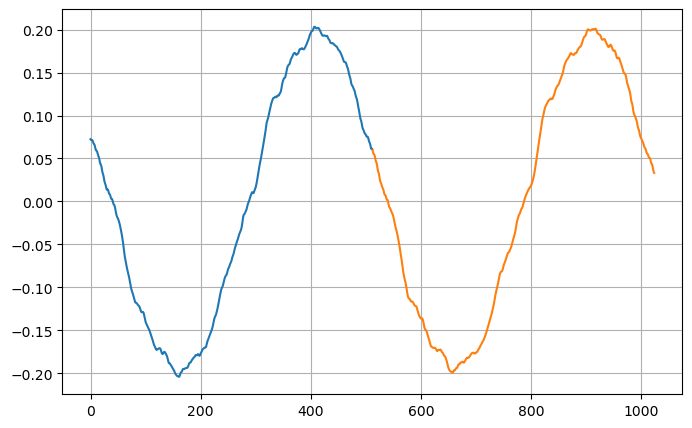

In [87]:
print(np.ones((theta_all_rad.shape[0], sequence_length+future_length)).shape)

plt.figure(figsize=(8, 5))
plt.plot( emf_past[0,:,0], label=' past emf Alpha')
plt.plot(range(sequence_length, sequence_length+future_length), emf_future[0,:,0], label=' future emf Alpha')

# plt.plot(emf_past[-1,:,0], label=' theta_all')
plt.grid(True)
plt.show()

### 物理模型擬合 ###

### 模型訓練 ###

1/1 [==============================] - 1s 626ms/step
Model structure passed, start training...
Epoch 1/100
422/422 [==============================] - 47s 106ms/step - loss: 0.0112 - val_loss: 5.9193e-04 - lr: 0.0010
Epoch 2/100
422/422 [==============================] - 44s 103ms/step - loss: 3.2192e-04 - val_loss: 4.6795e-04 - lr: 0.0010
Epoch 3/100
422/422 [==============================] - 44s 103ms/step - loss: 2.6117e-04 - val_loss: 2.1069e-04 - lr: 0.0010
Epoch 4/100
422/422 [==============================] - 44s 105ms/step - loss: 2.3750e-04 - val_loss: 1.9872e-04 - lr: 0.0010
Epoch 5/100
422/422 [==============================] - 44s 104ms/step - loss: 1.9760e-04 - val_loss: 1.2298e-04 - lr: 0.0010
Epoch 6/100
422/422 [==============================] - 63s 149ms/step - loss: 2.1465e-04 - val_loss: 9.0713e-05 - lr: 0.0010
Epoch 7/100
422/422 [==============================] - 99s 235ms/step - loss: 1.8595e-04 - val_loss: 2.0840e-04 - lr: 0.0010
Epoch 8/100
422/422 [=============

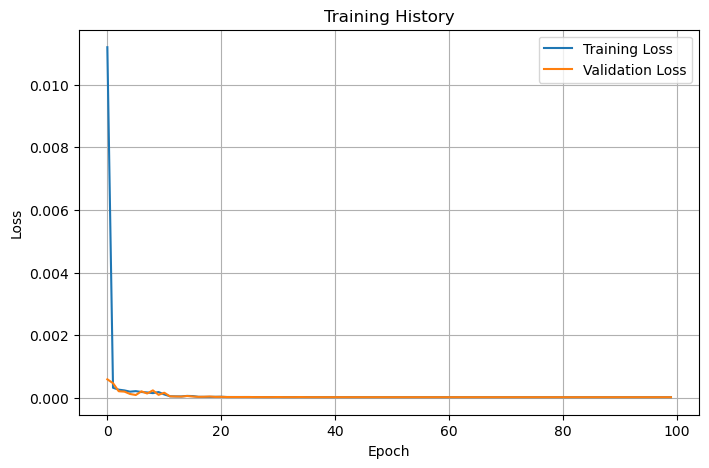

In [88]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
my_model.predict([emf_past[0:1,:,:], speed_array_pu[0:1,:], torque_array[0:1,:]])

print("Model structure passed, start training...")

# gpus = tf.config.experimental.list_physical_devices('GPU')
# print("GPU devices found:")
# for gpu in gpus:
#     print(gpu)
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)
        
def combined_time_freq_loss(y_true, y_pred):
    # 時域 MSE
    mse_time = tf.reduce_mean(tf.square(y_true - y_pred))
    # 頻域 MSE（幅值）
    fft_true = tf.signal.rfft(y_true)
    fft_pred = tf.signal.rfft(y_pred)
    mse_freq = tf.reduce_mean(tf.square(tf.abs(fft_true - fft_pred)))
    # 自訂權重，或動態調整
    return 0.7 * mse_time + 0.3 * mse_freq

        
# my_model.compile(
#     optimizer=Adam(learning_rate=1e-3),
#     loss=combined_time_freq_loss
# )

my_model.compile(
    
    
    optimizer=Adam(learning_rate=1e-3),
    loss='mse'
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# 加入 EarlyStopping（恢復最佳權重）
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,           # 若 val_loss 連續5次沒有改善，就停止訓練
    restore_best_weights=True,
    verbose=1
)



history = my_model.fit(
    x=[emf_past, speed_array_pu, torque_array], 
    y=emf_future,
    batch_size=128,
    epochs=100,
    validation_split=0.1, 
    callbacks=[lr_scheduler, early_stop] 
)

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

metadata = {
    "model_name": model_name,
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "trained": True,
    "train_date":  datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}
with open(os.path.join(model_path, model_name + '_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)

### 驗證結果 ###

Train input signals shape: (60000, 512, 4)
past_vi shape: (1, 512, 4)
speed_current_past shape: (1, 512, 2)
x_future shape: (1, 512, 2)
speed shape: ()
torque shape: ()
past_current shape: (512, 2)
current_diff_past shape: (1, 512, 2)  
1/1 [==============================] - 0s 99ms/step
1


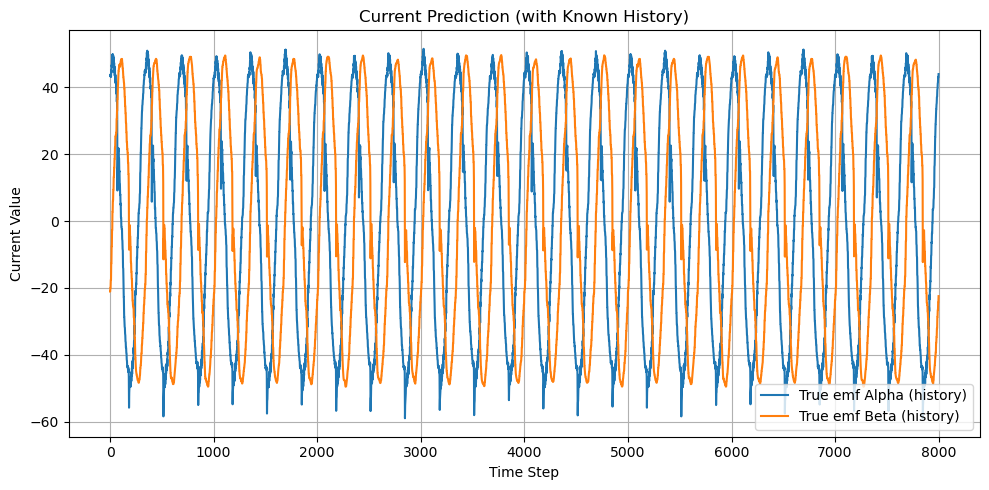

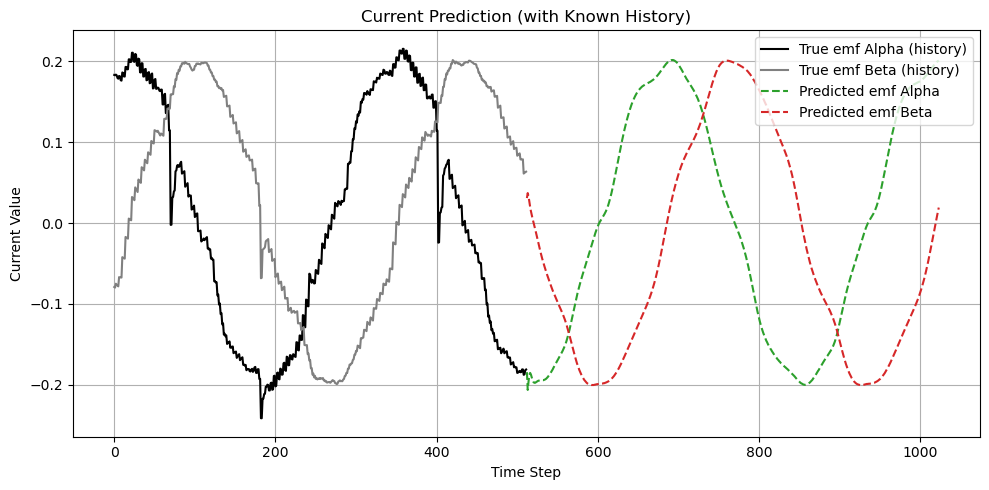

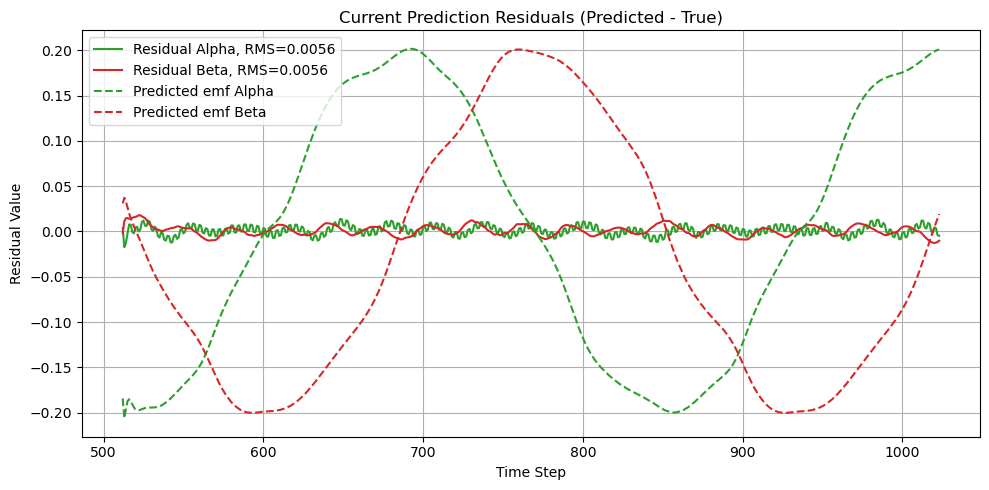

In [103]:
print(f"Train input signals shape: {train_input_signals.shape}")
# print(x_128.shape)
# === 載入測試資料 ===

# selected_folder=["1800_0_5V","1800_2_0V", "1200_1_0V",  "1200_0_5V"]  # 選擇特定資料夾
testfile=r"D:\OneDrive\CCAE_experiments\CCAE_datasets\Normal2\0611_1800_2_0V\RUL_Data_3_8.parquet"
# testfile=r"D:\OneDrive\CCAE_experiments\CCAE_datasets\drill 2X2\0531_1800_1_0V\RUL_Data_3_4.parquet"
test_data = read_rul_data(testfile)
start_idx=112

# test_data = read_rul_data(val_files[0])  # 使用第一個驗證檔案進行測試


import numpy as np
import matplotlib.pyplot as plt

def direct_forecast(model, past_voltage, past_current, future_voltage):
    """
    For MSSW_LSTM_AutoSplit version (accepts [past_vi_all, future_voltage])
    """
    past_vi_all = np.concatenate([past_voltage, past_current], axis=1)  # shape: (128, 4)
    past_vi_all = np.expand_dims(past_vi_all, axis=0).astype(np.float32)  # (1, 128, 4)
    future_voltage = np.expand_dims(future_voltage, axis=0).astype(np.float32)  # (1, 128, 2)

    pred_current, pred_torque, pred_speed = model.predict([past_vi_all, future_voltage], verbose=0)
    return pred_current, pred_torque, pred_speed  # 去掉 batch 維度

# V/I歷史輸入與未來電壓
past_vi = np.stack([
    test_data["Voltage alpha"][:sequence_length],
    test_data["Voltage beta"][:sequence_length],
    test_data["Current alpha downsample"][:sequence_length],
    test_data["Current beta downsample"][:sequence_length]
], axis=1)  # shape (128, 4)
past_vi=np.expand_dims(past_vi, axis=0).astype(np.float32)


speed_current_past = np.stack([
    test_data["Current alpha downsample"][:sequence_length]* test_data["Speed"][0]/3000,   
    test_data["Current beta downsample"][:sequence_length]* test_data["Speed"][0]/3000
], axis=1)  # shape (128, 2)
speed_current_past = np.expand_dims(speed_current_past, axis=0).astype(np.float32)  # (1, 128, 2)

current_diff_past = np.diff(past_vi[0, :, 2:4], axis=1, prepend=0)
current_diff_past = np.expand_dims(current_diff_past, axis=0).astype(np.float32)  # (1, 128, 2)

x_future = np.stack([
    test_data["Voltage alpha downsample"][sequence_length:sequence_length+future_length],
    test_data["Voltage beta downsample"][sequence_length:sequence_length+future_length]
], axis=1)
x_future=np.expand_dims(x_future, axis=0).astype(np.float32)  # (1, 128, 2)

true_future_current = np.stack([
    test_data["Current alpha downsample"][sequence_length:sequence_length+future_length],
    test_data["Current beta downsample"][sequence_length:sequence_length+future_length]
], axis=1)



# speed= (np.array(1800)/3000).astype(np.float32)

speed= (test_data["Speed"][0]/3000).astype(np.float32)
torque= (test_data["Torque avg"]).astype(np.float32)

true_future_emf =(x_future-true_future_current*Rs)/(speed*3000/60*2*np.pi)  # (1, 128, 2)

past_voltage = past_vi[0, :, 0:2]
past_current = past_vi[0, :, 2:4]

past_emf=(past_voltage-past_current*Rs)/(speed*3000/60*2*np.pi)  # 計算電動勢
time_stamp_all = np.arange(0, sequence_length + future_length,1)/Fs  # shape: (time_length,)
theta_all_rad = speed * 3000 / 60 * 2 *np.pi* time_stamp_all 
past_theta_apply = theta_all_rad[:sequence_length, None]  # 取前 sequence_length 個時間步長
past_theta_apply_cos_sin = np.concatenate([np.cos(past_theta_apply), np.sin(past_theta_apply)], axis=-1)  # 將 theta 轉為 sin/cos
future_theta = theta_all_rad[sequence_length:sequence_length+future_length, None]

# 確認資料形狀
# 印出輸入變數名稱與形狀
print(f"past_vi shape: {past_vi.shape}")
print(f"speed_current_past shape: {speed_current_past.shape}")
print(f"x_future shape: {x_future.shape}")
print(f"speed shape: {speed.shape}")
print(f"torque shape: {torque.shape}")
print(f"past_current shape: {past_current.shape}")  
print(f"current_diff_past shape: {current_diff_past.shape}  ")
  
  
# === 預測 ===
y_future_pred = my_model.predict([
    past_emf[None, :], 
    np.array([[speed]]), 
    np.array([[torque]])
])
print(len(y_future_pred))
y_future_pred=y_future_pred[0]  # 去掉 batch 維度

# === 繪圖：歷史 + 未來預測 ===
plt.figure(figsize=(10, 5))
plt.plot( test_data["Voltage alpha"], label='True emf Alpha (history)')
plt.plot( test_data["Voltage beta"], label='True emf Beta (history)')
# plt.plot(range(sequence_length, sequence_length+future_length), y_future_pred[:, 0], color='tab:green', linestyle='--', label='Predicted emf Alpha')
# plt.plot(range(sequence_length, sequence_length+future_length), y_future_pred[:, 1], color='tab:red', linestyle='--', label='Predicted emf Beta')
plt.title('Current Prediction (with Known History)')
plt.xlabel('Time Step')
plt.ylabel('Current Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# === 繪圖：歷史 + 未來預測 ===
plt.figure(figsize=(10, 5))
plt.plot(range(sequence_length), past_emf[:, 0], color='black', label='True emf Alpha (history)')
plt.plot(range(sequence_length), past_emf[:, 1], color='gray', label='True emf Beta (history)')
# plt.plot(range(sequence_length, sequence_length+future_length), true_future_emf[0, :, 0], color='tab:blue', label='True emf Alpha (future)')
# plt.plot(range(sequence_length, sequence_length+future_length), true_future_emf[0, :, 1], color='tab:orange', label='True emf Beta (future)')
plt.plot(range(sequence_length, sequence_length+future_length), y_future_pred[:, 0], color='tab:green', linestyle='--', label='Predicted emf Alpha')
plt.plot(range(sequence_length, sequence_length+future_length), y_future_pred[:, 1], color='tab:red', linestyle='--', label='Predicted emf Beta')
plt.title('Current Prediction (with Known History)')
plt.xlabel('Time Step')
plt.ylabel('Current Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 繪圖：預測誤差 ===

plt.figure(figsize=(10, 5))
residuals = y_future_pred - true_future_emf[0]
residual_rms= np.sqrt(np.mean(residuals**2, axis=0))
plt.plot(range(sequence_length, sequence_length+future_length), residuals[:, 0], color='tab:green', label=f'Residual Alpha, RMS={residual_rms[0]:.4f}')
plt.plot(range(sequence_length, sequence_length+future_length), residuals[:, 1], color='tab:red', label=f'Residual Beta, RMS={residual_rms[0]:.4f}')
# plt.plot(range(sequence_length, sequence_length+future_length), true_future_emf[0, :, 0], color='tab:blue', label='True emf Alpha (future)')
# plt.plot(range(sequence_length, sequence_length+future_length), true_future_emf[0, :, 1], color='tab:orange', label='True emf Beta (future)')
plt.plot(range(sequence_length, sequence_length+future_length), y_future_pred[:, 0], color='tab:green', linestyle='--', label='Predicted emf Alpha')
plt.plot(range(sequence_length, sequence_length+future_length), y_future_pred[:, 1], color='tab:red', linestyle='--', label='Predicted emf Beta')
plt.title('Current Prediction Residuals (Predicted - True)')
plt.xlabel('Time Step')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Second Part 同架構改純電流 ###

In [90]:
# from datetime import datetime
# import json
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import Input, LSTM, Dense, Average, Add, Multiply, Lambda, GlobalAveragePooling1D
# from tensorflow.keras import backend as K


# model_folder_path = r'NTU_rul_models\time_series_models'
# model_current_name = f'CCAE_direct_lstm_multiscale_Current_Base{sequence_length}Future{future_length}'
# model_current_path = os.path.join(model_folder_path, model_name)
# os.makedirs(model_path, exist_ok=True)

# # === 所有 Lambda 替代函數 ===

# def get_past_input_theta(x, past_length):
#     return x[:, :past_length, :]

# def get_future_input_theta(x, future_length):
#     return x[:, future_length:, :]

# def slice_quarter_fn(x):
#     return x[:, -x.shape[1] // 4:, :]

# def slice_half_fn(x):
#     return x[:, -x.shape[1] // 2:, :]

# def fusion_fn(x):
#     return (x[0] + x[1] + x[2]) / 3.0


# def build_multiscale_lstm_fusion_model_current(past_length=128, future_length=128, latent_dim=32):
    
#     # === 輸入 ===
#     past_input_current = Input(shape=(past_length, 2), name='past_input_emf')
#     input_all_theta = Input(shape=(past_length + future_length, 1), name='past_input_all_theta')

#     # 替代 lambda 使用 Lambda + 自定義函式（注意使用 arguments 傳參數）
#     past_input_theta = Lambda(get_past_input_theta, arguments={'past_length': past_length}, name='past_input')(input_all_theta)
#     future_input_theta = Lambda(get_future_input_theta, arguments={'future_length': future_length}, name='future_input')(input_all_theta)

#     # 合併過去序列
#     # 合併過去序列
#     past_input_all = Concatenate(axis=-1, name='past_input_all')([past_input_current, past_input_theta])
    
#     # 多尺度切片（具名函式取代 Lambda）
#     x_quarter = Lambda(slice_quarter_fn, name="slice_quarter")(past_input_all)
#     x_half = Lambda(slice_half_fn, name="slice_half")(past_input_all)
#     x_all = past_input_all

#     # === Decoder 分支（含 Conv1D 殘差） ===
#     def decoder_branch(x_in, name):
#         _, h, c = LSTM(latent_dim, return_state=True, name=f"{name}_enc")(x_in)
#         x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec")(future_input_theta, initial_state=[h, c])
#         # Conv1D 濾出局部變化（不做殘差）
#         # x = Conv1D(32, kernel_size=3, padding='same', activation='relu', name=f"{name}_conv")(x)
#         return Dense(2, name=f"{name}_out")(x)

#     out_64 = decoder_branch(x_quarter, "net64")
#     out_96 = decoder_branch(x_half, "net96")
#     out_128 = decoder_branch(x_all, "net128")
    
#     # === 融合：學習式 softmax 加權平均 ===
#     def fusion_block(out_list, name="fusion"):
#         # 拼接所有輸出 (B, T, 6)
#         concat = Concatenate(name=f"{name}_concat")(out_list)
#         # 計算每個分支的 softmax 權重 (B, T, 3)
#         fusion_weights = Dense(3, activation='softmax', name=f"{name}_weights")(concat)
#         fusion_weights = Lambda(lambda x: tf.expand_dims(x, axis=-1), name=f"{name}_expand")(fusion_weights)  # (B, T, 3, 1)

#         # 堆疊預測值 (B, T, 3, 2)
#         pred_stack = Lambda(lambda x: tf.stack(x, axis=-2), name=f"{name}_stack")(out_list)

#         # 權重相乘 + 求和
#         weighted = Multiply(name=f"{name}_multiply")([fusion_weights, pred_stack])  # (B, T, 3, 2)
#         fused = Lambda(lambda x: tf.reduce_sum(x, axis=-2), name=f"{name}_output")(weighted)  # (B, T, 2)
#         return fused
    
#     # === 融合：簡單平均（取代學習式 softmax） ===
#     output_emf = Lambda(fusion_fn, name="fusion_output")([out_64, out_96, out_128])

#     model = Model(
#         inputs=[past_input_current, past_input_theta, future_input_theta],
#         outputs=[output_emf],
#         name="MSSW_LSTM_MultiTask3"
#     )

#     return model

# # build model 
# my_model_current = build_multiscale_lstm_fusion_model_current(past_length=sequence_length, future_length=future_length, latent_dim=128)
# my_model_current.compile(optimizer='adam', loss='mse')
# metadata = {
#     "model_name": model_name,
#     "sequence_length": sequence_length,
#     "layer_number": layer_number,
#     "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
#     "trained": False,
#     "train_date": None,
# }
# with open(os.path.join(model_current_path, model_current_name + '_metadata.json'), "w", encoding="utf-8") as f:
#     json.dump(metadata, f, ensure_ascii=False, indent=4)

# plot_model(my_model_current, to_file=os.path.join(model_current_path, model_current_name+'.png'), show_shapes=True, show_layer_names=True)

# my_model_current.predict([train_input_signals[0:1,:,-2:], past_theta[0:1,:,:], future_theta[0:1,:,:]])
# print("Model structure passed, start training...")

# gpus = tf.config.experimental.list_physical_devices('GPU')
# print("GPU devices found:")
# for gpu in gpus:
#     print(gpu)
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=5,
#     min_lr=1e-6,
#     verbose=1
# )

# # 加入 EarlyStopping（恢復最佳權重）
# early_stop = EarlyStopping(
#     monitor='val_loss',
#     patience=5,           # 若 val_loss 連續5次沒有改善，就停止訓練
#     restore_best_weights=True,
#     verbose=1
# )

# history = my_model_current.fit(
#     x=[train_input_signals[:,:,-2:], past_theta, future_theta], 
#     y=train_fit_signals[:,:,:2],
#     batch_size=128,
#     epochs=20,
#     validation_split=0.1, 
#     callbacks=[lr_scheduler, early_stop] 
# )

# plt.figure(figsize=(8, 5))
# plt.plot(history.history['loss'], label='Training Loss')
# if 'val_loss' in history.history:
#     plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training History')
# plt.legend()
# plt.grid(True)
# plt.show()

# metadata = {
#     "model_name": model_current_name,
#     "sequence_length": sequence_length,
#     "layer_number": layer_number,
#     "trained": True,
#     "train_date":  datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
# }
# with open(os.path.join(model_path, model_current_name + '_metadata.json'), "w", encoding="utf-8") as f:
#     json.dump(metadata, f, ensure_ascii=False, indent=4)

# print(f"Train input signals shape: {train_input_signals.shape}")
# # print(x_128.shape)
# # === 載入測試資料 ===

# # selected_folder=["1800_0_5V","1800_2_0V", "1200_1_0V",  "1200_0_5V"]  # 選擇特定資料夾
# testfile=r"D:\OneDrive\CCAE_experiments\CCAE_datasets\Normal2\0611_1800_2_0V\RUL_Data_3_2.parquet"
# # testfile=r"D:\OneDrive\CCAE_experiments\CCAE_datasets\drill 2X2\0531_1800_1_0V\RUL_Data_3_4.parquet"
# test_data = read_rul_data(testfile)
# start_idx=112

# # V/I歷史輸入與未來電壓
# past_vi = np.stack([
#     test_data["Voltage alpha downsample"][:sequence_length],
#     test_data["Voltage beta downsample"][:sequence_length],
#     test_data["Current alpha downsample"][:sequence_length],
#     test_data["Current beta downsample"][:sequence_length]
# ], axis=1)  # shape (128, 4)
# past_vi=np.expand_dims(past_vi, axis=0).astype(np.float32)


# speed_current_past = np.stack([
#     test_data["Current alpha downsample"][:sequence_length]* test_data["Speed"][0]/3000,   
#     test_data["Current beta downsample"][:sequence_length]* test_data["Speed"][0]/3000
# ], axis=1)  # shape (128, 2)
# speed_current_past = np.expand_dims(speed_current_past, axis=0).astype(np.float32)  # (1, 128, 2)

# x_future = np.stack([
#     test_data["Voltage alpha downsample"][sequence_length:sequence_length+future_length],
#     test_data["Voltage beta downsample"][sequence_length:sequence_length+future_length]
# ], axis=1)
# x_future=np.expand_dims(x_future, axis=0).astype(np.float32)  # (1, 128, 2)

# true_future_current = np.stack([
#     test_data["Current alpha downsample"][sequence_length:sequence_length+future_length],
#     test_data["Current beta downsample"][sequence_length:sequence_length+future_length]
# ], axis=1)


# past_emf=(past_voltage-past_current*Rs)/(speed*3000/60*2*np.pi)  # 計算電動勢
# time_stamp_all = np.arange(0, sequence_length + future_length,1)/Fs  # shape: (time_length,)
# theta_all_rad = speed * 3000 / 60 * 2 *np.pi* time_stamp_all 
# past_theta = theta_all_rad[:sequence_length, None]  # 取前 sequence_length 個時間步長
# future_theta = theta_all_rad[sequence_length:sequence_length+future_length, None]

# # 確認資料形狀
# # 印出輸入變數名稱與形狀
# print(f"past_vi shape: {past_vi.shape}")
# print(f"speed_current_past shape: {speed_current_past.shape}")
# print(f"x_future shape: {x_future.shape}")
# print(f"speed shape: {speed.shape}")
# print(f"torque shape: {torque.shape}")
# print(f"past_current shape: {past_current.shape}")  
# print(f"current_diff_past shape: {current_diff_past.shape}  ")
  
  
# # === 預測 ===
# y_future_pred = my_model_current.predict([
#     past_vi[:,:,-2:], 
#     past_theta[None, :], 
#     future_theta[None, :]
# ])
# print(len(y_future_pred))
# y_future_pred=y_future_pred[0]  # 去掉 batch 維度


# # === 繪圖：歷史 + 未來預測 ===
# plt.figure(figsize=(10, 5))
# plt.plot(range(sequence_length), past_current[:, 0], color='black', label='True emf Alpha (history)')
# plt.plot(range(sequence_length), past_current[:, 1], color='gray', label='True emf Beta (history)')
# plt.plot(range(sequence_length, sequence_length+future_length), true_future_current[ :, 0], color='tab:blue', label='True emf Alpha (future)')
# plt.plot(range(sequence_length, sequence_length+future_length), true_future_current[ :, 1], color='tab:orange', label='True emf Beta (future)')
# plt.plot(range(sequence_length, sequence_length+future_length), y_future_pred[:, 0], color='tab:green', linestyle='--', label='Predicted emf Alpha')
# plt.plot(range(sequence_length, sequence_length+future_length), y_future_pred[:, 1], color='tab:red', linestyle='--', label='Predicted emf Beta')
# plt.title('Current Prediction (with Known History)')
# plt.xlabel('Time Step')
# plt.ylabel('Current Value')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # === 繪圖：預測誤差 ===

# plt.figure(figsize=(10, 5))
# residuals = y_future_pred - true_future_current[0]
# residual_rms= np.sqrt(np.mean(residuals**2, axis=0))
# plt.plot(range(sequence_length, sequence_length+future_length), residuals[:, 0], color='tab:green', label=f'Residual Alpha, RMS={residual_rms[0]:.4f}')
# plt.plot(range(sequence_length, sequence_length+future_length), residuals[:, 1], color='tab:red', label=f'Residual Beta, RMS={residual_rms[0]:.4f}')
# plt.title('Current Prediction Residuals (Predicted - True)')
# plt.xlabel('Time Step')
# plt.ylabel('Residual Value')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


### 導入 RUL 資料 ###

In [91]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 假設你已經定義好了這些（要根據你自己的實作引入）
# from your_module import read_rul_data, 
# , my_model, Rs, Fs, sequence_length, future_length

def process_rul_folder_avg_mse_batch(RUL_test_folder, sequence_length, future_length, augmen_sample_number, Rs, Fs):
    rul_files = [os.path.join(RUL_test_folder, f) for f in os.listdir(RUL_test_folder) if f.endswith(".parquet")]
    rul_files.sort(key=lambda f: int(os.path.splitext(os.path.basename(f))[0].split('_')[-1]))

    # 用來累積所有檔案的 augmentation 結果
    all_input_seq = []
    all_future_seq = []
    all_torque = []
    all_speed = []
    file_index_ranges = []

    total_index = 0

    for file_path in rul_files:
        df = read_rul_data(file_path)

        signals = np.stack([
            np.array(df["Voltage alpha downsample"]),
            np.array(df["Voltage beta downsample"]),
            np.array(df["Current alpha downsample"]),
            np.array(df["Current beta downsample"])
        ], axis=1)

        augmented = data_random_augmentation(
            signals,
            sequence_length=sequence_length,
            augmen_sample_number=augmen_sample_number,
            future_length=future_length
        )

        input_seq = augmented[:, :sequence_length, :]
        future_seq = augmented[:, sequence_length:, :]

        torque = df["Torque avg"]
        speed = df["Speed"][0] / 3000

        torque_array = np.ones((augmen_sample_number, 1)) * torque
        speed_array_pu = np.ones((augmen_sample_number, 1)) * speed

        all_input_seq.append(input_seq)
        all_future_seq.append(future_seq)
        all_torque.append(torque_array)
        all_speed.append(speed_array_pu)

        file_index_ranges.append((total_index, total_index + augmen_sample_number))
        total_index += augmen_sample_number

    # 合併所有資料
    input_seq_all = np.concatenate(all_input_seq, axis=0)
    future_seq_all = np.concatenate(all_future_seq, axis=0)
    torque_all = np.concatenate(all_torque, axis=0)
    speed_all = np.concatenate(all_speed, axis=0) # per unit speed

    # theta 計算
    time_sequence_all = np.arange(0, sequence_length + future_length)[None, :, None] / Fs
    theta_all_rad = speed_all[:, None, :] * time_sequence_all * 3000 / 60 * 2 * np.pi
    past_theta = theta_all_rad[:, :sequence_length, :]
    future_theta = theta_all_rad[:, sequence_length:, :]

    # emf 計算
    emf_past = (input_seq_all[:, :, 0:2] - input_seq_all[:, :, 2:4] * Rs) / (speed_all[:, None, :] * 3000 / 60 * 2 * np.pi)
    emf_future_true = (future_seq_all[:, :, 0:2] - future_seq_all[:, :, 2:4] * Rs) / (speed_all[:, None, :] * 3000 / 60 * 2 * np.pi)

    # 批量預測
    emf_future_pred = my_model.predict([emf_past, speed_all, torque_all], verbose=1)

    # 計算每段 MSE
    mse_per_sample = np.mean((emf_future_pred - emf_future_true) ** 2, axis=(1, 2))

    # 回分每個檔案的平均 MSE
    errors = []
    for start_idx, end_idx in file_index_ranges:
        file_mse = np.mean(mse_per_sample[start_idx:end_idx])
        errors.append(file_mse)

    return np.array(errors)



augmen_sample_number = 100

RUL_test_folder1 = r"D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0703_3000_10P_1.0V_1"
errors1 = process_rul_folder_avg_mse_batch(RUL_test_folder1, sequence_length, future_length, augmen_sample_number, Rs, Fs)

RUL_test_folder2 = r"D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0710_3000_10_1.0v_3"
errors2 = process_rul_folder_avg_mse_batch(RUL_test_folder2, sequence_length, future_length, augmen_sample_number, Rs, Fs)

RUL_test_folder3 = r"D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0718_1200_15p_1.0v_1"
errors3 = process_rul_folder_avg_mse_batch(RUL_test_folder3, sequence_length, future_length, augmen_sample_number, Rs, Fs)


1110/1110 [==============================] - 39s 35ms/step


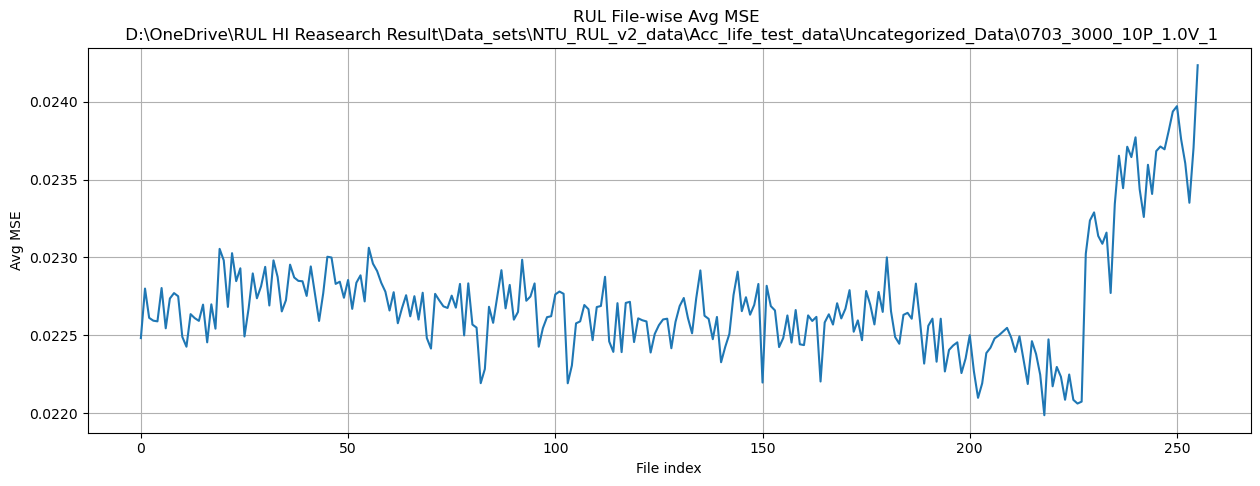

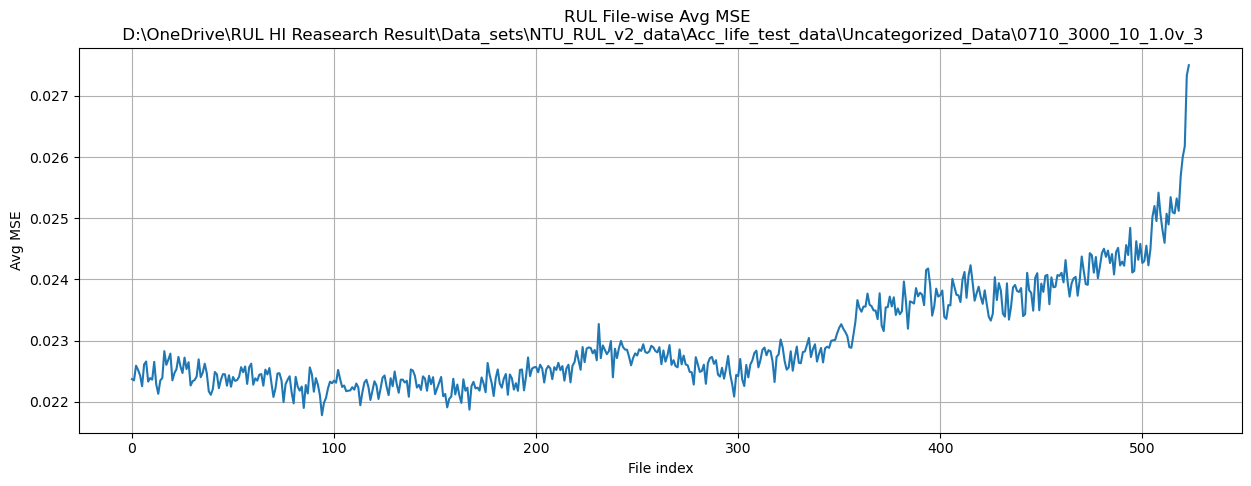

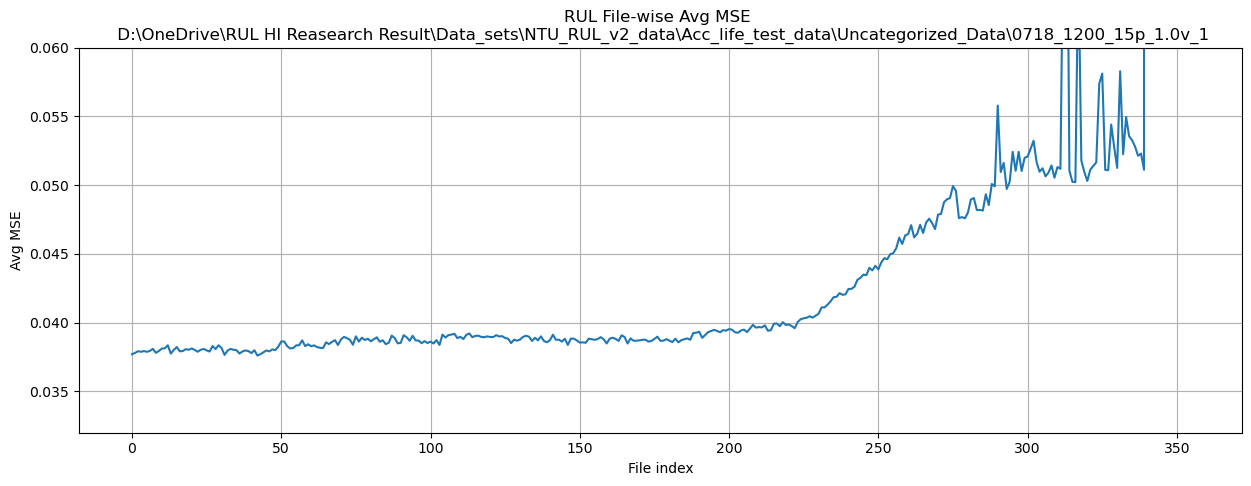

In [92]:

# 顯示結果
plt.figure(figsize=(15, 5))
plt.plot(errors1)
plt.title(f"RUL File-wise Avg MSE \n {RUL_test_folder1}")
plt.xlabel("File index")
plt.ylabel("Avg MSE")
# plt.ylim(0.04, 0.1)
plt.grid()
plt.show()

# 顯示結果
plt.figure(figsize=(15, 5))
plt.plot(errors2)
plt.title(f"RUL File-wise Avg MSE \n {RUL_test_folder2}")
plt.xlabel("File index")
plt.ylabel("Avg MSE")
# plt.ylim(0.04, 0.1)
plt.grid()
plt.show()

# 顯示結果
plt.figure(figsize=(15, 5))
plt.plot(errors3)
plt.title(f"RUL File-wise Avg MSE \n {RUL_test_folder3}")
plt.xlabel("File index")
plt.ylabel("Avg MSE")
plt.ylim(0.032, 0.06)
plt.grid()
plt.show()

